In [4]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import SeqGen
import RacetrackSetup as rt
import MCM

In [8]:
def initLearning(track_shape):
    QShape = track_shape + (rt.MAX_VELOCITY+1, rt.MAX_VELOCITY+1, rt.ACTIONS_NUM)
    np.random.seed(113)
    Q = (np.random.random(QShape)-0.5)*0.001 - 300.0
    return Q

REWARD = -1

def setupEnvironment(rt_contour, start_line, finish_line, Q, episodes_to_generate = 1000):
    sequence = SeqGen.SequenceGeneratorPlus(
                SeqGen.EpsilonGreedyPolicy(Q, 0.1),
                lambda: rt.getStartPosition(start_line),
                lambda s,a: rt.getTransition(
                        rt_contour, s, a, finish_line, 
                        getStartPosition=lambda: rt.getStartPosition(start_line))
                    + (REWARD,),
                episodes_max=episodes_to_generate
               )
    return sequence

class ImmutableGreedyPolicy:
    def __init__(self, Q):
        self.action = np.argmax(Q,axis=-1);
        
    def __call__(self, state):
        return self.action[state]

### Setup Environment #2

In [24]:
Q = initLearning(rt.track_shape_2)
sequence = setupEnvironment(rt.contour_2, rt.start_line_2, rt.finish_line_2, Q)

### Run Off-policy MC Control learning

In [25]:
C = np.zeros(dtype=np.float, shape=Q.shape)
#t_policy = getGreedyPolicy(Q)
MCM.learnByEpisode(sequence, 
                   lambda e,i: MCM.OffPolicyMCControl(e, Q, C, 
                                sequence.get_action.getDistribution, 0.99))

 Episode #:    1000; length:      13
Episodes generated: 1000


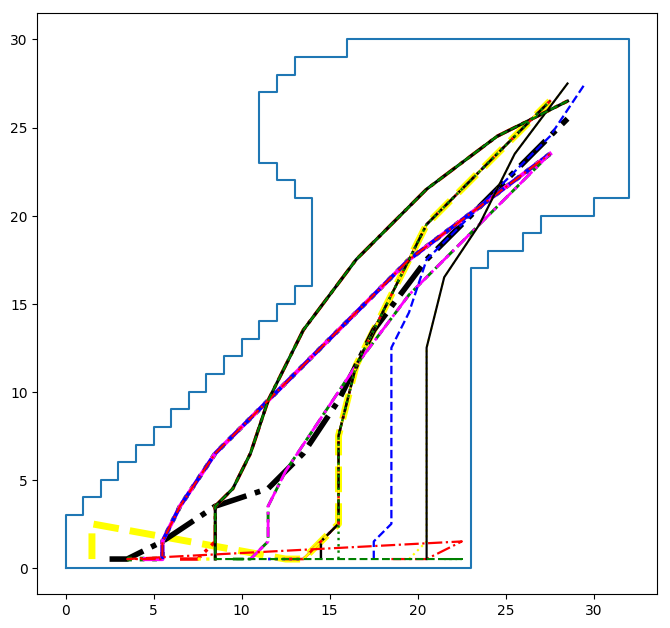

In [30]:
plotTraces(rt.contour_2, getTraces(rt.contour_2, rt.start_line_2, rt.finish_line_2, Q))

### Run On-policy First Visit MC Control learning

In [ ]:
C = np.zeros(shape=Q.shape, dtype=int)
MCM.learnByEpisode(sequence, lambda e,i: MCM.OnPolicyFirstVisitMCControl(e, Q, C, 0.99))

### Run On-policy Every Visit MC Control learning

In [5]:
sequence = setupEnvironment(rt.contour_2, rt.start_line_2, rt.finish_line_2, Q)

In [7]:
C = np.zeros(shape=Q.shape, dtype=int)
MCM.learnByEpisode(sequence, lambda e,i: MCM.OnPolicyEveryVisitMCControl(e, Q, C, 0.99))

 Episode #:    1000; length:      35
Episodes generated: 1000


### Setup Environment #1

In [31]:
Q_1 = initLearning(rt.track_shape_1)
sequence = setupEnvironment(rt.contour_1, rt.start_line_1, rt.finish_line_1, Q_1)

In [32]:
C_1 = np.zeros(dtype=np.float, shape=Q_1.shape)
#t_policy = getGreedyPolicy(Q)
MCM.learnByEpisode(sequence, 
                   lambda e,i: MCM.OffPolicyMCControl(e, Q_1, C_1, 
                                sequence.get_action.getDistribution, 0.99))

 Episode #:    1000; length:      15
Episodes generated: 1000


### Plot the optimal paths

In [29]:
def getTraces(contour, start_line, finish_line, Q):
    epi = start_line[0]
    def startPosition():
        #global epi
        return (epi,0,0,0)

    test_gen = SeqGen.SequenceGeneratorPlus(
        ImmutableGreedyPolicy(Q), 
        startPosition,
        lambda s,a: rt.getTransition(contour, s, a, finish_line, 
                            getStartPosition=lambda: rt.getStartPosition(start_line))
                        + (REWARD,),
        episodes_max = start_line[2]-start_line[0],
        episode_maxlen = 40
        )

    traces = []
    episode = []
    for state, is_terminal, next_state, action, reward in test_gen:
        episode.append(state[0:2])
        if is_terminal:
            traces.append(np.array(episode)+0.5)
            episode = []
            epi += 1

    return traces

def plotTraces(contour, traces):
    f = plt.figure(num=None, figsize=(8,10), dpi=100, facecolor='w', edgecolor='k')
    plt.axes().set_aspect('equal')
    cont = np.array(contour)
    plt.plot(cont[:,0], cont[:,1], figure=f)
    cols = ['red','yellow','black','green','magenta','blue']
    wids = [4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0]
    lnst = ['-', '--', '-.', ':']

    for i, trace in enumerate(traces):
        plt.plot(trace[:,0], trace[:,1], figure=f, linewidth=1+12/(i+2),  #wids[i%len(wids)], 
                 color=cols[i%len(cols)], ls=lnst[i%len(lnst)])


In [16]:
lnst = ['-', '--', '-.', ':']
wids = [4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0]
t[17%len(wids)]

':'

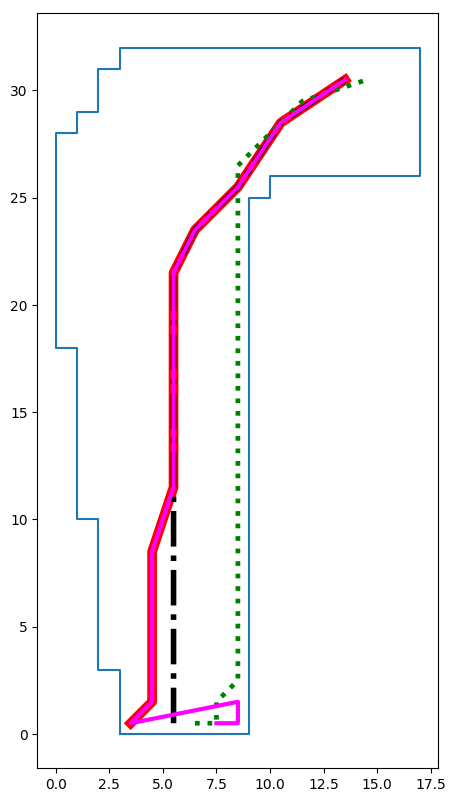

In [33]:
plotTraces(rt.contour_1, getTraces(rt.contour_1, rt.start_line_1, rt.finish_line_1, Q_1))